Name : Krishna Kant Verma (2211cs19)</br>
Name : Gaurob Chatterjee (2211cs08)</br>
NLP Assignment 2  </br>
NER Recognition


All important Library Needed for NER Tagging

In [ ]:
import json
import numpy as np
from nltk.util import ngrams
from collections import Counter, defaultdict, namedtuple
from tabulate import tabulate
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Smoothing Factor (Laplace Correction)
Tag = namedtuple("Tag", ["token", "tag"])
LAPLACE = 0.0000001

Function that Loads Dataset for the NER Recognition

In [ ]:
def loadData(filename, sep="\t", encoding='utf-8'):
    sequences = []
    with open(filename, encoding=encoding) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if line[1] != 'O':
                    line[1] = line[1][2:]
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences

Function that calculates Transition Matrix

In [ ]:
def findTransitionMatrix(y, ngram=2, laplace_factor=LAPLACE):
    ngram_tags = []
    for tag_list in y:
        tag_list = ["*"] * (ngram - 1) + tag_list + ["STOP"]
        ngram_tags.extend(ngrams(tag_list, ngram))
    ngram_count = dict(Counter(ngram_tags))

    n_minus_1_gram_tags = []
    for tag_list in y:
        tag_list = ["*"] * (ngram - 1) + tag_list + ["STOP"]
        n_minus_1_gram_tags.extend(ngrams(tag_list, ngram - 1))
    n_minus_1_gram_count = dict(Counter(n_minus_1_gram_tags))

    transition_matrix = defaultdict(lambda: laplace_factor)

    for ngram_tuple in ngram_count:
        n_minus_1_gram_tuple = ngram_tuple[:-1]
        transition_matrix[ngram_tuple] = ngram_count[ngram_tuple] / n_minus_1_gram_count[n_minus_1_gram_tuple]

    return transition_matrix

Function that Calculates Emission Matrix

In [ ]:
def findEmissionMatrix(x, y, with_context=False, laplace_factor=LAPLACE):
    word_tag_count = defaultdict(lambda: 0)
    tag_count = defaultdict(lambda: 0)

    for line, tags in zip(x, y):
        prev_tag = '*'
        for word, tag in zip(line, tags):
            if with_context:
                tag_count[(tag, prev_tag)] += 1
                word_tag_count[(word, tag, prev_tag)] += 1
            else:
                tag_count[(tag,)] += 1
                word_tag_count[(word, tag)] += 1
            prev_tag = tag
            
    
    emission_matrix = defaultdict(lambda: laplace_factor)
    
    for word_tags in word_tag_count.keys():
        tags = word_tags[1:]
        emission_matrix[word_tags] = word_tag_count[word_tags] / tag_count[tags]

    return emission_matrix

In [ ]:
def kappa(position, allTags):
    return allTags if position not in [0, -1] else ['*']

Implementing Viterbi Algorithm for Trigram Assumption

In [ ]:
def viterbiAlgoritmForTrigram(sentence, transition, emission, allTags, with_context=False):
    pi = defaultdict(lambda: 0)
    bp = defaultdict(lambda: "OTH")
    pi[(0, '*', '*')] = 1.0

    n = len(sentence)

    for k in range(1, n + 1):
        uSET = kappa(k - 1, allTags)
        vSET = kappa(k, allTags)
        wordSet = kappa(k - 2, allTags)

        for v in vSET:
            for u in uSET:
                for w in wordSet:
                    if with_context:
                        emission_tuple = (sentence[k - 1], v, u)
                    else:
                        emission_tuple = (sentence[k - 1], v)
                    reach_prob = pi[(k - 1, w, u)] * transition[(w, u, v)] * emission[emission_tuple]
                    if reach_prob > pi[(k, u, v)]:
                        pi[(k, u, v)] = reach_prob
                        bp[(k, u, v)] = w
    
    uSET = kappa(n - 1, allTags)
    vSET = kappa(n, allTags)
    resultTags = []
    for u in uSET:
        for v in vSET:
            if len(resultTags) == 0:
                resultTags = [v, u]
            if pi[(n, u, v)] * transition[(u, v, 'STOP')] > \
            pi[(n, resultTags[1], resultTags[0])] * transition[resultTags[1], resultTags[0], 'STOP']:
                resultTags = [v, u]
    
    if n == 0:
        return []
    
    elif n == 1:
        return [resultTags[0]]
    
    for k in range(n - 2, 0, -1):
        resultTags.append(bp[(k + 2, resultTags[-1], resultTags[-2])])
    
    resultTags.reverse()

    return resultTags

Implementing Viterbi For Bi-gram Assumptions

In [ ]:
def viterbiAlgoritmForBigram(sentence, transition, emission, allTags, with_context=False):
    pi = defaultdict(lambda: 0)
    bp = defaultdict(lambda: "OTH")
    pi[(0, '*')] = 1.0

    n = len(sentence)

    for k in range(1, n + 1):
        uSET = kappa(k - 1, allTags)
        vSET = kappa(k, allTags)

        for v in vSET:
            for u in uSET:
                if with_context:
                    emission_tuple = (sentence[k - 1], v, u)
                else:
                    emission_tuple = (sentence[k - 1], v)
                reach_prob = pi[(k - 1, u)] * transition[(u, v)] * emission[emission_tuple]
                if reach_prob > pi[(k, v)]:
                    pi[(k, v)] = reach_prob
                    bp[(k, v)] = u
    
    vSET = kappa(n, allTags)
    resultTags = []
    for v in vSET:
        if len(resultTags) == 0:
            resultTags = [v]
        if pi[(n, v)] * transition[(v, 'STOP')] > \
        pi[(n, resultTags[0])] * transition[resultTags[0], 'STOP']:
            resultTags = [v]
        
    if n == 0:
        return []
    
    for k in range(n - 1, 0, -1):
        resultTags.append(bp[(k + 1, resultTags[-1])])
    
    resultTags.reverse()

    return resultTags


Calling Viterbi Algorithm

In [ ]:
def viterbiAlgorithm(sentence, transition, emission, allTags, ngram=2, with_context=False):
    if ngram == 3:
        return viterbiAlgoritmForTrigram(sentence, transition, emission, allTags, with_context)
    return viterbiAlgoritmForBigram(sentence, transition, emission, allTags, with_context)

Evaluation of Metrices for the HMM Model For NER Recognition

In [ ]:
def evaluateMetricsForHMM(true, pred):
    true = [ch for word in true for ch in word]
    pred = [ch for word in pred for ch in word]
    classes = list(set(true))
    classes.sort()
    # accuracy: (tp + tn) / (p + n)
    acc = accuracy_score(true, pred)
    # precision tp / (tp + fp)
    precision = precision_score(true, pred, average=None)
    # recall: tp / (tp + fn)
    recall = recall_score(true, pred, average=None)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(true, pred, average=None)

    return acc, precision, recall, f1, classes

Printing Metrices (Precision Recall F-Score)

In [ ]:
def printEvaluationMetric(test_acc, precision, recall, f1, classes):
    print(f"Accuracy of the model: {test_acc}")
    print(tabulate(zip(classes, precision, recall, f1),
                   headers=['Class', 'Precision', 'Recall', 'F1'],
                   tablefmt='orgtbl'))

Function Which Test And Evaluate the Desired Result

In [ ]:
def testAndEvaluate(test, true, transition, emission, allTags, ngram=2, with_context=False):
    pred = []

    for sentence in tqdm(test, total=len(test)):
        pred.append(viterbiAlgorithm(sentence, transition, emission, allTags, ngram, with_context))
    
    ngramString = 'trigram' if ngram == 3 else 'bigram'
    contextString = 'with' if with_context else 'without'
    predictions_file = open(f"predictions_{ngramString}_{contextString}_context.txt", "w")
    for test_sentence, pred_tag_seq in zip(test, pred):
        for word, tag in zip(test_sentence, pred_tag_seq):
            predictions_file.write(f'{word} {tag}\n')
        predictions_file.write('\n')

    accuracy, precision, recall, f1, classes = evaluateMetricsForHMM(true, pred)
    printEvaluationMetric(accuracy, precision, recall, f1, classes)       

Function for training and testing the model

In [ ]:
def trainAndTest(dataset, ngram=2, with_context=False):
    X_train, Y_train, X_test, Y_test = dataset

    # Train
    allTags = ['*'] + list(set(tag for tag_list in Y_train for tag in tag_list)) + ['STOP']
    emissionMatrix = findEmissionMatrix(X_train, Y_train, with_context=with_context)
    transitionMatrix = findTransitionMatrix(Y_train, ngram=ngram)

    # Test and Evaluate Metrics
    print('-' * 80)
    ngramString = 'trigram' if ngram == 3 else 'bigram'
    contextString = 'with' if with_context else 'without'
    print(f'Evaluation on {ngramString} model {contextString} context')

    testAndEvaluate(X_test, Y_test, transitionMatrix, emissionMatrix, allTags, ngram=ngram, with_context=with_context)
    
    print(f"\nEvaluated {len(X_test)} sentences.\n")

Loading dataset

In [ ]:
dataTrain = loadData('/content/NER-Dataset-Train.txt')
dataTest = loadData('/content/test_data_NER.txt')
print("Train_Data",dataTrain)
print("Test_data",dataTest)

Train_Data [[Tag(token='@LewisDixon', tag='O'), Tag(token='Trust', tag='O'), Tag(token='me', tag='O'), Tag(token='!', tag='O'), Tag(token='im', tag='O'), Tag(token='gonna', tag='O'), Tag(token='be', tag='O'), Tag(token='bringing', tag='O'), Tag(token='out', tag='O'), Tag(token='music', tag='O'), Tag(token='like', tag='O'), Tag(token='theres', tag='O'), Tag(token='no', tag='O'), Tag(token='tomorrow', tag='O'), Tag(token=',', tag='O'), Tag(token='Be', tag='O'), Tag(token='doing', tag='O'), Tag(token='pure', tag='O'), Tag(token='blog', tag='O'), Tag(token='videos', tag='O'), Tag(token='&amp;', tag='O'), Tag(token='freestyle', tag='O'), Tag(token='videos', tag='O'), Tag(token='#Moesh', tag='O'), Tag(token='!', tag='O')], [Tag(token='@joshHnumber1fan', tag='O'), Tag(token='its', tag='O'), Tag(token='okay', tag='O'), Tag(token='then', tag='O'), Tag(token='..', tag='O'), Tag(token='make', tag='O'), Tag(token='it', tag='O'), Tag(token='when', tag='O'), Tag(token='it', tag='O'), Tag(token='work

Testing DataSet With 5-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
X_train = [[tagged_token.token for tagged_token in sequence] for sequence in dataTrain]
Y_train = [[tagged_token.tag for tagged_token in sequence] for sequence in dataTrain]
X_test = [[tagged_token.token for tagged_token in sequence] for sequence in dataTest] 
Y_test = [[tagged_token.tag for tagged_token in sequence] for sequence in dataTest]

dataset = (X_train, Y_train, X_test, Y_test)
ngram_options = [2, 3]
context_options = [False, True]
num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f'Fold {fold+1}')
    x_train_fold = [X_train[i] for i in train_idx]
    y_train_fold = [Y_train[i] for i in train_idx]
    x_val_fold = [X_train[i] for i in val_idx]
    y_val_fold = [Y_train[i] for i in val_idx]
    fold_dataset = (x_train_fold, y_train_fold, x_val_fold, y_val_fold)

    for ngram in ngram_options:
        for with_context in context_options:
            trainAndTest(fold_dataset, ngram=ngram, with_context=with_context)

Fold 1
--------------------------------------------------------------------------------
Evaluation on bigram model without context


100%|██████████| 181/181 [00:00<00:00, 2305.42it/s]

Accuracy of the model: 0.9562554680664916
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.911765 | 0.300971 | 0.452555 |
| O       |    0.957156 | 0.998138 | 0.977217 |

Evaluated 181 sentences.



--------------------------------------------------------------------------------
Evaluation on bigram model with context


100%|██████████| 181/181 [00:00<00:00, 2368.69it/s]


Accuracy of the model: 0.9568387284922718
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.891892 | 0.320388 | 0.471429 |
| O       |    0.958271 | 0.997518 | 0.977501 |

Evaluated 181 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model without context


100%|██████████| 181/181 [00:00<00:00, 784.81it/s]


Accuracy of the model: 0.9553805774278216
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.907692 | 0.286408 | 0.435424 |
| O       |    0.956302 | 0.998138 | 0.976772 |

Evaluated 181 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model with context


100%|██████████| 181/181 [00:00<00:00, 658.95it/s]


Accuracy of the model: 0.9562554680664916
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.868421 | 0.320388 | 0.468085 |
| O       |    0.958246 | 0.996897 | 0.97719  |

Evaluated 181 sentences.

Fold 2
--------------------------------------------------------------------------------
Evaluation on bigram model without context


100%|██████████| 180/180 [00:00<00:00, 2739.51it/s]


Accuracy of the model: 0.9541595925297114
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.584906 | 0.181287 | 0.276786 |
| O       |    0.959782 | 0.993458 | 0.97633  |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on bigram model with context


100%|██████████| 180/180 [00:00<00:00, 2315.16it/s]


Accuracy of the model: 0.9564233163554047
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.666667 | 0.19883  | 0.306306 |
| O       |    0.960666 | 0.994945 | 0.977505 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model without context


100%|██████████| 180/180 [00:00<00:00, 684.02it/s]


Accuracy of the model: 0.9533106960950763
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.551724 | 0.187135 | 0.279476 |
| O       |    0.960012 | 0.992269 | 0.975874 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model with context


100%|██████████| 180/180 [00:00<00:00, 660.87it/s]


Accuracy of the model: 0.9572722127900396
| Class   |   Precision |   Recall |      F1 |
|---------+-------------+----------+---------|
|         |    0.692308 | 0.210526 | 0.32287 |
| O       |    0.961229 | 0.995242 | 0.97794 |

Evaluated 180 sentences.

Fold 3
--------------------------------------------------------------------------------
Evaluation on bigram model without context


100%|██████████| 180/180 [00:00<00:00, 2746.95it/s]


Accuracy of the model: 0.9395047833427125
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.754098 | 0.186992 | 0.299674 |
| O       |    0.942743 | 0.995466 | 0.968387 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on bigram model with context


100%|██████████| 180/180 [00:00<00:00, 2099.82it/s]


Accuracy of the model: 0.939786156443444
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.742424 | 0.199187 | 0.314103 |
| O       |    0.943521 | 0.994861 | 0.968511 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model without context


100%|██████████| 180/180 [00:00<00:00, 692.56it/s]


Accuracy of the model: 0.939786156443444
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.785714 | 0.178862 | 0.291391 |
| O       |    0.942253 | 0.996372 | 0.968557 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model with context


100%|██████████| 180/180 [00:00<00:00, 690.20it/s]


Accuracy of the model: 0.9414743950478335
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.806452 | 0.203252 | 0.324675 |
| O       |    0.943872 | 0.996372 | 0.969412 |

Evaluated 180 sentences.

Fold 4
--------------------------------------------------------------------------------
Evaluation on bigram model without context


100%|██████████| 180/180 [00:00<00:00, 2894.14it/s]


Accuracy of the model: 0.9569612940496822
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.730769 | 0.219653 | 0.337778 |
| O       |    0.960411 | 0.995743 | 0.977758 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on bigram model with context


100%|██████████| 180/180 [00:00<00:00, 1869.21it/s]


Accuracy of the model: 0.9586943963027152
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.857143 | 0.208092 | 0.334884 |
| O       |    0.959942 | 0.998176 | 0.978685 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model without context


100%|██████████| 180/180 [00:00<00:00, 779.15it/s]


Accuracy of the model: 0.9572501444251877
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.727273 | 0.231214 | 0.350877 |
| O       |    0.960963 | 0.995439 | 0.977897 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model with context


100%|██████████| 180/180 [00:00<00:00, 704.51it/s]


Accuracy of the model: 0.9584055459272097
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.853659 | 0.202312 | 0.327103 |
| O       |    0.959661 | 0.998176 | 0.978539 |

Evaluated 180 sentences.

Fold 5
--------------------------------------------------------------------------------
Evaluation on bigram model without context


100%|██████████| 180/180 [00:00<00:00, 2849.47it/s]


Accuracy of the model: 0.9557269351613824
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.714286 | 0.198864 | 0.311111 |
| O       |    0.959154 | 0.995789 | 0.977129 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on bigram model with context


100%|██████████| 180/180 [00:00<00:00, 1176.86it/s]


Accuracy of the model: 0.9528706083976007
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.590164 | 0.204545 | 0.303797 |
| O       |    0.959302 | 0.992481 | 0.97561  |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model without context


100%|██████████| 180/180 [00:00<00:00, 526.98it/s]


Accuracy of the model: 0.9560125678377607
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.711538 | 0.210227 | 0.324561 |
| O       |    0.959698 | 0.995489 | 0.977266 |

Evaluated 180 sentences.

--------------------------------------------------------------------------------
Evaluation on trigram model with context


100%|██████████| 180/180 [00:00<00:00, 292.55it/s]


Accuracy of the model: 0.9531562410739789
| Class   |   Precision |   Recall |       F1 |
|---------+-------------+----------+----------|
|         |    0.59375  | 0.215909 | 0.316667 |
| O       |    0.959849 | 0.99218  | 0.975747 |

Evaluated 180 sentences.



# RNN : Recurrent Neural Network (RNN Based Model FrameWork)
An RNN is a type of neural network that can process sequential data by maintaining a hidden state, which is updated at each time step using the input and the previous hidden state. The main features of an RNN are:

    Hidden state: The RNN maintains a hidden state that is updated at each time step and serves as a memory of the previous inputs.

    Time dependency: The output of the RNN at each time step depends not only on the current input but also on the previous inputs, through the hidden state.

    Parameter sharing: The same set of weights is used at each time step, which allows the network to learn to process sequential data of varying length.

The architecture of an RNN for NER tagging typically involves an input layer, an RNN layer, and an output layer.

The input layer receives a sequence of token embeddings, which are typically generated using pre-trained word embeddings, such as GloVe or Word2Vec. These embeddings capture the semantic and syntactic features of the tokens in the sequence.

The RNN layer processes the input sequence by maintaining a hidden state at each time step, which is updated using the input at that time step and the previous hidden state. The output of the RNN layer at each time step is typically a vector of hidden states, which captures the contextual information of the token within the sequence.

The output layer maps the hidden states of the RNN layer to a sequence of named entity labels. This is typically done using a softmax layer, which computes the probability distribution over the possible entity labels for each token in the sequence. The label with the highest probability is then assigned to the corresponding token.

During training, the weights of the RNN layer and the output layer are updated using backpropagation through time (BPTT), which propagates the error signal from the output layer back through the RNN layer to update the weights. The objective is typically to minimize the cross-entropy loss between the predicted labels and the true labels.

Overall, an RNN for NER tagging is a powerful and effective approach for identifying named entities in text, as it can capture the contextual dependencies between tokens in the input sequence.

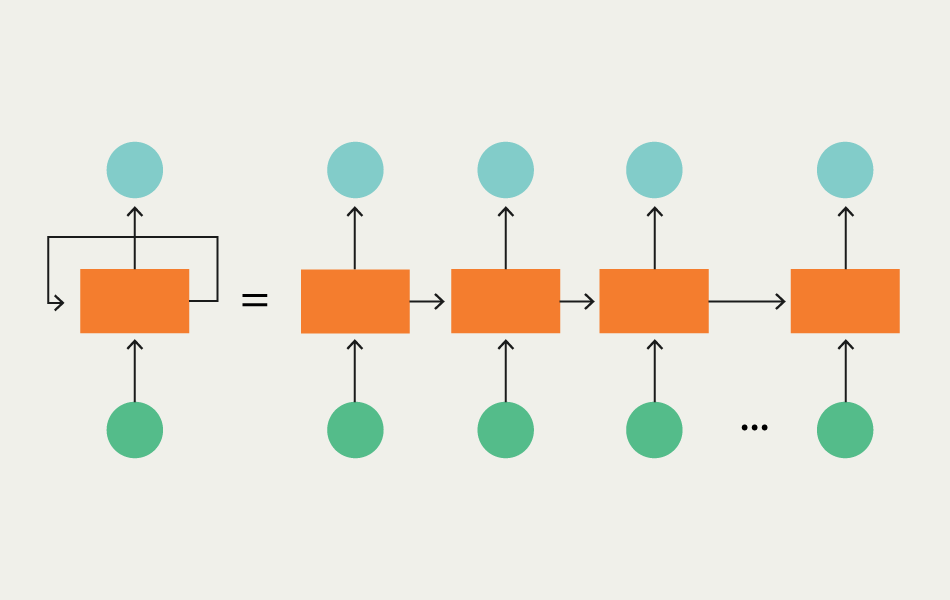

The architecture of the RNN for NER tagging is shown below:

      x1         x2         ...         xn
      |          |                     |
      V          V                     V
    [embedding] [embedding]  ...  [embedding]
      |          |                     |
      V          V                     V
    [RNN cell] [RNN cell]   ...  [RNN cell]
      |          |                     |
      V          V                     V
    [dense]    [dense]      ...  [dense]
      |          |                     |
      V          V                     V
      y1         y2         ...         yn

The architecture described in the question is a standard RNN-based approach for NER tagging. The input sequence of tokens is first passed through an embedding layer, which converts each token into a fixed-length vector of features. These features capture important information about the token, such as its meaning, its part-of-speech tag, or its context within the sentence.

The embedded sequence is then fed into a sequence of RNN cells, each of which updates the hidden state based on the input and the previous hidden state. The hidden state serves as a kind of "memory" of the previous inputs, allowing the network to capture long-term dependencies between tokens in the sequence. By using the same set of weights at each time step, the network can learn to process sequences of varying length.

The output of each RNN cell is passed through a dense layer that maps the hidden state to a vector of scores for each possible tag. The dense layer typically consists of a set of learnable weights and biases that are optimized during training to minimize a loss function. The purpose of the dense layer is to map the hidden state to a vector of tag scores, which can be interpreted as the probability of each tag given the current input and the previous hidden state.

Finally, the sequence of tag scores is transformed into a sequence of tags using a softmax activation function. The softmax function normalizes the tag scores so that they sum to 1, and converts them into probabilities. The tag with the highest probability is then chosen as the predicted tag for the corresponding token in the sequence.

Overall, the architecture described in the question is effective for NER tagging because it can capture the sequential nature of the task and the context-dependent relationships between tokens and their corresponding named entity labels. The RNN cells and the dense layer allow the network to learn complex patterns in the data and make accurate tag predictions for each token in the sequence.

//THANK YOU SO MUCH